<h1> <center><font color='green' > <b>AGN Classifier for AGNDB</b></font> </center></h1>

# Data Preprocessing
by Sicong Huang <br> \
<font color='blue'>Python Version: 3.6.5 <br>
AGNDB Version: 1.1.0

# THE QUESTION: <br><font color='green'>How to use ML methods to classify agn and non-agns?</font>

# Goal of Data Preprocessing
<font color='green'>Nico: "We need to get rid of the galaxies and stars in our database. They are useless!" <br>
<font color='red'>
- Test new database (v1.1.0)
- Identify AGN and non-AGN in our database so as to remove the non-AGN contaimination.
- Downsampling AGN to remove data imbalance.
- Creat training, dev and testing sets for ML models.
- Use TSNE plot for clustering visulizaion.   
    

# Analytic Approach
<font color='green'>__Machine learning & deep learning__:
- Logistic Regression
- Kernal SVM
- Random Forest
- Convolutional Neural Network

# IMPORT LIBRARIES

In [263]:
# System
import os
import glob
from tqdm import tqdm
from IPython.display import Markdown, display, Audio

# Web Scraping

# Data Analysis
import pandas as pd
from pandas_profiling import ProfileReport
import numpy as np
from scipy import stats
from sklearn.manifold import TSNE


# Data Visualization
import matplotlib.pyplot as plt
import plotnine as p9
import seaborn as sns
%matplotlib inline

# Functions

In [264]:
def sound_effect(fail=0):
    """
    Play a sound when job is finished
    """
    if fail == 0:
        sound_file = '/data/home/sicong/sounds/jobs-done_1.mp3'
        display(Audio(sound_file, autoplay=True))
    else:
        sound_file = '/data/home/sicong/sounds/oh-shit-im-sorry_0001.mp3'
        display(Audio(sound_file, autoplay=True))

In [2]:
def printmd(string):
    """
    print in markdown style
    """
    display(Markdown(string))

In [3]:
printmd("**<font color='purple'>This is a test.**")

**<font color='purple'>This is a test.**

In [52]:
def non_nan_percent(df, cols):
    '''
    This function returns the percentage 
    of non-NaN values sorted by percentage
    '''
    perc = {col:f"{len(df[col].dropna())/len(df[col])*100 :.2f} %" for col in cols}
    perc = dict(sorted(perc.items(), key=lambda item: float(item[1].split('%')[0]), reverse=True))
    return perc

In [53]:
def nan_percent(df, cols):
    '''
    This function returns the percentage 
    of NaN values sorted by percentage
    '''
    perc = {col:f"{(1-len(df[col].dropna())/len(df[col]))*100 :.2f} %" for col in cols}
    perc = dict(sorted(perc.items(), key=lambda item: float(item[1].split('%')[0]), reverse=False))
    return perc

In [54]:
def combine_columns(df, column_names):
    '''
    This function merges the columns 
    with first come first serve order
    and returns a new df series
    '''
    col = df[column_names[0]]
    for name in column_names[1:]:
        col = col.combine_first(df[name])
    return col

In [55]:
def predict(x):
    '''simple liear regression'''
    return slope*x + intercept

# Data Requirements 
Identify the necessary data content, formats and sources for initial data collection.

In [8]:
glob.glob('/data/blackbase/final/*master*')

['/data/blackbase/final/master-Redshift-store.csv',
 '/data/blackbase/final/master-Morphology-store.csv',
 '/data/blackbase/final/master-Photometry-store.csv',
 '/data/blackbase/final/master-converted-Photometry-store.csv',
 '/data/blackbase/final/master-merged-Photometry-store.csv',
 '/data/blackbase/final/master-merged-Redshift-store.csv',
 '/data/blackbase/final/master-converted-Morphology-store.csv',
 '/data/blackbase/final/master-merged-Morphology-store.csv',
 '/data/blackbase/final/master-merged-all-store.csv']

In [7]:
# master tables
morph_csv = '/data/blackbase/final/master-merged-Morphology-store.csv'
photo_csv = '/data/blackbase/final/master-merged-Photometry-store.csv'
redshift_csv = '/data/blackbase/final/master-merged-Redshift-store.csv'

# Data Collection
Perform data collection and data assessment.

In [8]:
# read into pandas dataframe
df_morph_original = pd.read_csv('/data/blackbase/final/master-merged-Morphology-store.csv');
df_photo_original = pd.read_csv('/data/blackbase/final/master-merged-Photometry-store.csv');
df_redshift_original = pd.read_csv('/data/blackbase/final/master-merged-Redshift-store.csv');

/home/jack/.pyenv/versions/3.6.5/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (3,7,8,9,10,11) have mixed types.Specify dtype option on import or set low_memory=False.
/home/jack/.pyenv/versions/3.6.5/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (4,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34) have mixed types.Specify dtype option on import or set low_memory=False.


In [9]:
printmd(f'We have {len(df_photo_original)} sources.')

We have 1436614 sources.

In [10]:
printmd(f'We have {len(df_photo_original.columns)} columns for photometry datasets.')
printmd(f'We have {len(df_redshift_original.columns)} columns for redshift datasets.')
printmd(f'We have {len(df_morph_original.columns)} columns for morphology datasets.')

We have 204 columns for photometry datasets.

We have 19 columns for redshift datasets.

We have 13 columns for morphology datasets.

# Data Preparation
Data must be prepared in a way that addresses missing or invalid values and removes duplicates, toward ensuring that everything is properly formatted.

## Feature Selection

<font color='green'>Before we move on, let's set the 'np.NaN' values in __df_morph_original__ to be 'unknown'. In this way, the classification column won't affect the sorting of master table based on missing values.

In [11]:
df_morph_original['best_class'] = df_morph_original['best_class'].replace(np.NaN, 'unknown')

<font color='green'>There are too many unwanted columns in the original master tables. We need to select the features we want and remove the others.

In [12]:
# look at all the columns we have in the original table
# with non-Nan percentage
printmd("**<font color='red'>Photometry table columns:**")
perc = non_nan_percent(df_photo_original,df_photo_original.columns)
print(*perc.items(), sep='\n')
print('-'*100)

printmd("**<font color='red'>Classification table columns:**")
perc = non_nan_percent(df_morph_original,df_morph_original.columns)
print(*perc.items(), sep='\n')
print('-'*100)

printmd("**<font color='red'>Redshift table columns:**")
perc = non_nan_percent(df_redshift_original,df_redshift_original.columns)
print(*perc.items(), sep='\n')

**<font color='red'>Photometry table columns:**

('Unnamed: 0', '100.00 %')
('Unnamed: 0.1', '100.00 %')
('Unnamed: 0.1.1', '100.00 %')
('RA', '100.00 %')
('DEC', '100.00 %')
('u_extinction', '53.33 %')
('u_mag', '51.34 %')
('r_mag', '51.33 %')
('i_mag', '51.08 %')
('g_mag', '50.81 %')
('z_mag', '50.74 %')
('e_i_mag', '50.45 %')
('e_z_mag', '50.45 %')
('e_r_mag', '50.41 %')
('e_u_mag', '50.40 %')
('e_g_mag', '47.25 %')
('r_extinction', '45.96 %')
('g_extinction', '44.89 %')
('i_extinction', '43.56 %')
('z_extinction', '43.56 %')
('W1_mag', '41.57 %')
('E_B-V', '33.97 %')
('e_rf10', '23.37 %')
('rf10', '23.37 %')
('e_rf12', '23.37 %')
('rf12', '23.37 %')
('W2_mag', '21.41 %')
('e_W1_mag', '21.38 %')
('W3_mag', '21.37 %')
('W4_mag', '21.37 %')
('e_W2_mag', '21.21 %')
('e_W4_mag', '18.30 %')
('e_W3_mag', '18.09 %')
('e_counts', '10.42 %')
('counts', '10.42 %')
('e_xf2', '10.28 %')
('xf2', '10.28 %')
('e_xf6', '10.16 %')
('xf6', '10.16 %')
('e_xf16', '10.04 %')
('xf16', '10.04 %')
('e_xf15', '9.91 %')
('xf15', '9.91 %')
('e_xf17', '9.83 

**<font color='red'>Classification table columns:**

('Unnamed: 0', '100.00 %')
('Unnamed: 0.1', '100.00 %')
('Unnamed: 0.1.1', '100.00 %')
('RA', '100.00 %')
('DEC', '100.00 %')
('best_class', '100.00 %')
('xray_class', '66.58 %')
('spec_class', '48.95 %')
('gen_class', '44.00 %')
('SED_class', '40.90 %')
('image_class', '10.88 %')
('SP_TYPE_simbad', '2.68 %')
('nan_column', '0.00 %')
----------------------------------------------------------------------------------------------------


**<font color='red'>Redshift table columns:**

('Unnamed: 0', '100.00 %')
('Unnamed: 0.1', '100.00 %')
('Unnamed: 0.1.1', '100.00 %')
('RA', '100.00 %')
('DEC', '100.00 %')
('best_Z', '52.27 %')
('f_best_Z', '52.27 %')
('q_Z', '50.37 %')
('phot_Z', '43.67 %')
('p_phot_Z', '43.60 %')
('max_phot_Z', '43.47 %')
('min_phot_Z', '42.06 %')
('spec_Z', '17.62 %')
('Z', '17.09 %')
('e_spec_Z', '13.74 %')
('e_best_Z', '13.74 %')
('nan_column', '0.00 %')
('e_phot_Z', '0.00 %')
('e_Z', '0.00 %')


<font color='green'>*best_class* column in df_morph_original and *best_Z* column in df_redshift_original are created by following order:<br>
- "spec_class" > "SDSS_image_class" > "SED_class" > "vi_class" > "optical_class" > "gen_class" > "Mtype"

In [84]:
# check if df_morph_original, df_photo_original and df_redshift_original shares the same index system,
# i.e, if the same index corresponds to the same source
if df_photo_original['RA'].equals(df_morph_original['RA']):
    print('photometry and morphology table have the same indices.')

if df_photo_original['RA'].equals(df_redshift_original['RA']):
    print('photometry and redshift table have the same indices.')

photometry and morphology table have the same indices.
photometry and redshift table have the same indices.


In [13]:
# merge with df_photo_original
df_photo_original['best_class'] = df_morph_original["best_class"]
df_photo_original['best_z'] = df_redshift_original["best_Z"]
df_photo_original['best_z_error'] = df_redshift_original["e_best_Z"]

In [86]:
df_photo_original.head(5)

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Velocity_ned,Magnitude and Filter_ned,Photometry Points_ned,FLUX_SYSTEM_U_simbad,FLUX_QUAL_U_simbad,FLUX_UNIT_U_simbad,FLUX_SYSTEM_B_simbad,...,snr_r,snr_u,snr_z,snr_W1,snr_W2,snr_W3,snr_W4,best_class,best_z,best_z_error
0,0,0,0,809807.0,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,unknown,2.7010,0.0
1,1,1,1,278.0,0.9,51.0,NaN,NaN,NaN,NaN,...,4.90,1.48,3.48,33.85,34.65,30.4,5.75,galaxy,2.4150,0.0
2,2,2,2,NaN,NaN,6.0,False,False,False,False,...,2.54,1.45,2.38,23.90,15.60,3.5,0.50,galaxy,3.5100,0.0
3,3,3,3,NaN,20.3g,5.0,NaN,NaN,NaN,NaN,...,14.61,3.31,8.01,37.50,37.45,16.9,4.95,galaxy,0.7213,0.0
4,4,4,4,870897.0,20.9g,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,galaxy,2.3780,0.0


<font color='green'>Select the features we want:
    select top 5% rows and columns with missing values < 30%

In [ ]:
# sort the df based on missing value counts where the least NaN rows are at the top
df = df_photo_original.iloc[df_photo_original.isnull().sum(axis=1).mul(1).argsort()]

In [202]:
df = df.loc[:round(len(df)*0.05)] 

In [206]:
#perc = non_nan_percent(df_photo_original,df_photo_original.columns)
perc = non_nan_percent(df,df.columns)

useful_columns = [k for k,v in perc.items() if float(v[:v.index('%')]) > 70]
# remove wanted columns
useful_columns.remove('Unnamed: 0')
useful_columns.remove('Unnamed: 0.1')
useful_columns.remove('Unnamed: 0.1.1')
#useful_columns.remove('uv_NBCKDE.fit')

print(useful_columns)

['RA', 'DEC', 'best_class', 'best_z', 'i_mag', 'r_mag', 'z_mag', 'u_mag', 'g_mag', 'e_i_mag', 'e_z_mag', 'e_r_mag', 'e_u_mag', 'u_extinction', 'r_extinction', 'e_g_mag', 'g_extinction', 'i_extinction', 'z_extinction', 'e_rf10', 'rf10', 'e_rf12', 'rf12', 'W1_mag', 'W2_mag', 'e_W1_mag', 'W4_mag', 'W3_mag', 'e_W2_mag']


In [207]:
df = df[useful_columns]

In [208]:
# check the missing value count
df[:100].apply(lambda x: x.count(), axis=1)

31        29
5         29
1         29
19        29
157       29
          ..
34209     29
34434     29
34114     29
215094    18
273       29
Length: 100, dtype: int64

In [209]:
len(df)

192044

<font color='green'> Check the missing values again

In [210]:
perc = nan_percent(df,df.columns)
print(f'{len(perc)} columns:')
print(*perc.items(),sep='\n')

29 columns:
('RA', '0.00 %')
('DEC', '0.00 %')
('best_class', '0.00 %')
('best_z', '7.73 %')
('i_mag', '8.24 %')
('r_mag', '8.33 %')
('z_mag', '8.36 %')
('u_mag', '8.45 %')
('g_mag', '8.47 %')
('e_i_mag', '8.76 %')
('e_z_mag', '8.76 %')
('e_r_mag', '9.00 %')
('e_u_mag', '9.01 %')
('u_extinction', '9.26 %')
('r_extinction', '11.57 %')
('e_g_mag', '12.56 %')
('g_extinction', '13.56 %')
('i_extinction', '16.76 %')
('z_extinction', '16.78 %')
('e_rf10', '23.63 %')
('rf10', '23.63 %')
('e_rf12', '23.63 %')
('rf12', '23.63 %')
('W1_mag', '27.66 %')
('W2_mag', '28.50 %')
('e_W1_mag', '28.58 %')
('W4_mag', '28.64 %')
('W3_mag', '28.65 %')
('e_W2_mag', '29.01 %')


<font color='blue'> After feature engineering, we only select top 5% rows with at least 70% available data. <br>
    The majority of the ML training would depend on optical magnitude columns.

<font color='green'>Replace AGN=1 and non-AGN=0 in __best_class__ column.

In [211]:
df['best_class'].value_counts()

generic_agn    163070
unknown         11485
galaxy           5081
type2            4705
star             4615
type1            2660
blazar            426
false               2
Name: best_class, dtype: int64

In [212]:
df.rename(columns = {'best_class':'AGN'}, inplace = True)
df['AGN'].replace({'generic_agn':True,
                   'blazar':True,
                   'star':False,
                   'galaxy':False,
                   'type1':True,
                   'type2':True,
                   'lens_system':True,
                   'unknown': np.nan,
                   'false':False
                    }, inplace=True)

In [213]:
df['AGN']=df['AGN'].astype('float')

## Downsampling AGN to the same number of non-AGN

In [214]:
print(f"AGN: {len(df[df['AGN']==1]):.2f}, \
      non-AGN: {len(df[df['AGN']==0]):.2f}, \
      NaN: {df['AGN'].isna().sum():.2f}")
print(f"AGN: {100*len(df[df['AGN']==1])/len(df):.2f}%, \
      non-AGN: {100*len(df[df['AGN']==0])/len(df):.2f}%, \
      NaN: {100*df['AGN'].isna().sum()/len(df):.2f}%")

AGN: 170861.00,       non-AGN: 9698.00,       NaN: 11485.00
AGN: 88.97%,       non-AGN: 5.05%,       NaN: 5.98%


In [215]:
df.head(50)

,RA,DEC,AGN,best_z,i_mag,r_mag,z_mag,u_mag,g_mag,e_i_mag,...,e_rf10,rf10,e_rf12,rf12,W1_mag,W2_mag,e_W1_mag,W4_mag,W3_mag,e_W2_mag
31,318.841683,12.300792,0.0,1.233161,17.352909,19.997735,22.210000,20.355066,20.373289,0.017647,...,6.840000e+00,94.020000,2.976636e+05,0.132923,16.578309,16.599377,0.027,14.6240,15.475,0.027
5,130.169860,13.290490,0.0,1.964000,20.776632,20.896219,20.465952,21.393705,21.124334,0.007345,...,6.160000e+00,107.840000,3.542632e+05,0.112824,18.920000,19.310000,0.070,15.4630,15.960,0.180
1,39.768000,25.920000,0.0,2.415000,20.858900,20.851000,19.140000,20.866000,21.322000,0.007500,...,8.680000e+00,188.450000,1.145706e+05,0.315646,17.113495,17.178203,0.027,14.8000,15.900,0.027
19,218.345400,60.120800,0.0,1.311151,21.340172,21.758242,17.630604,22.376859,22.416345,0.014812,...,4.070000e+00,77.480000,2.312496e+05,0.098265,16.882976,17.043664,0.026,15.9370,15.771,0.026
157,206.030610,-0.475670,0.0,2.273000,19.620714,19.670056,17.644936,20.752479,20.018521,0.014999,...,4.850000e+00,61.940000,3.501226e+05,0.088145,17.230388,17.075575,0.029,15.5070,15.549,0.029
64031,150.090792,22.555169,1.0,2.766000,16.860906,20.234067,16.851913,20.156110,20.142405,0.015198,...,6.500000e+00,88.230000,2.813452e+05,0.127644,16.775583,16.502588,0.028,15.3200,15.861,0.028
460,0.285917,19.242828,0.0,2.375000,17.402841,20.264114,19.070000,20.371759,20.349059,0.014947,...,5.350000e+00,55.820000,4.985584e+05,0.072444,16.872552,17.039300,0.028,13.3580,14.332,0.028
462,0.325000,-7.774078,0.0,2.439000,21.216860,21.210220,17.687835,21.509406,21.513775,0.011302,...,6.850000e+00,84.490000,5.487622e+05,0.084023,17.725882,17.511274,0.038,15.6350,16.524,0.038
13062,10.921876,0.881479,1.0,0.834200,18.631000,19.457511,17.936000,22.198470,20.501553,0.005000,...,7.096000e+01,3081.770000,7.722420e+02,4.943107,15.292000,14.611000,2.724,13.1150,13.699,3.361
30,340.125975,3.358508,0.0,2.146300,21.880000,20.313700,21.840000,20.743828,20.429867,0.010000,...,8.070000e+00,85.900000,4.763404e+05,0.115133,16.868066,16.957554,0.029,14.4640,15.886,0.029


In [216]:
# select top 9698 AGN so AGN:non-AGN is 50:50
df_nonagn = df.loc[df['AGN'] != 1.]
df_agn = df.loc[df['AGN'] == 1.]
df_agn = df_agn.iloc[:9698]
df = pd.concat([df_agn, df_nonagn])

In [217]:
# check agn:non-agn ratio in new df
print(f"AGN: {len(df[df['AGN']==1]):.2f}, \
      non-AGN: {len(df[df['AGN']==0]):.2f}, \
      NaN: {df['AGN'].isna().sum():.2f}")
print(f"AGN: {100*len(df[df['AGN']==1])/len(df):.2f}%, \
      non-AGN: {100*len(df[df['AGN']==0])/len(df):.2f}%, \
      NaN: {100*df['AGN'].isna().sum()/len(df):.2f}%")

AGN: 9698.00,       non-AGN: 9698.00,       NaN: 11485.00
AGN: 31.40%,       non-AGN: 31.40%,       NaN: 37.19%


In [218]:
# check types
df.dtypes

RA              float64
DEC             float64
AGN             float64
best_z          float64
i_mag           float64
r_mag           float64
z_mag           float64
u_mag           float64
g_mag           float64
e_i_mag         float64
e_z_mag         float64
e_r_mag         float64
e_u_mag         float64
u_extinction    float64
r_extinction    float64
e_g_mag         float64
g_extinction    float64
i_extinction    float64
z_extinction    float64
e_rf10          float64
rf10            float64
e_rf12          float64
rf12            float64
W1_mag          float64
W2_mag          float64
e_W1_mag        float64
W4_mag          float64
W3_mag          float64
e_W2_mag        float64
dtype: object

## Train/dev/test set split
<font color='green'>
<ul>
  <li>We will use all labeled data for Train/Dev set, and the remaining unlabeled data as Test set.</li>
  <li>To ensure that dev and test sets come from the same distribution, we first select 80% of the labeled data as training set, and after imputation with train/test median values, we then divide the remaining data as dev/test set.</li>
</ul>

In [235]:
# labeled data
df_labeled = df[~np.isnan(df['AGN'])]

# unlabeled data for test set
df_test = df[np.isnan(df['AGN'])]

# divide labeled data for train/dev with train set = 80%
df_train, df_dev = np.split(df_labeled.sample(frac=1, random_state=42), [int(.8*len(df_labeled))])

# merge dev/test set
df_dev_test = pd.concat([df_dev, df_test])

In [222]:
len(df_dev)

3880

In [223]:
assert len(df_train)+len(df_dev)+len(df_test)==len(df),"length not equal!"
assert len(df_train)+len(df_dev)==len(df_labeled),"length not equal!"
assert len(df_test)+len(df_dev)==len(df_dev_test),"length not equal!"
assert df_train['AGN'].isnull().values.sum()==0,"Unlabeled data in train set!"
assert df_dev['AGN'].isnull().values.sum()==0,"Unlabeled data in dev set!"

## Remove outliers
<font color='green'>
<ul>
  <li>replace values beyond Q1-1.5IQR and Q3+1.5IQR with boundary values </li>
</ul>

In [236]:
features = list(set(df_train.columns) - {'best_class','AGN','RA','DEC'})
for col in features:
    q1 =  df_train[col].quantile(0.25)
    q3 =  df_train[col].quantile(0.75)
    iqr = q3-q1
    assert iqr!=0, f'train-{col}: Q1 = Q3 = {q1}!'
    q_low = q1-1.5*iqr
    q_hi  = q3+1.5*iqr
    df_train.loc[df_train[col] > q_hi, col] = q_hi
    df_train.loc[df_train[col] < q_low, col] = q_low
    
    q1 =  df_dev_test[col].quantile(0.25)
    q3 =  df_dev_test[col].quantile(0.75)
    iqr = q3-q1
    assert iqr!=0, f'test-{col}: Q1 = Q3 = {q1}!'
    q_low = q1-1.5*iqr
    q_hi  = q3+1.5*iqr
    df_dev_test.loc[df_dev_test[col] > q_hi, col] = q_hi
    df_dev_test.loc[df_dev_test[col] < q_low, col] = q_low

## Missing Values

<font color='green'> Check train/dev/test set missing values

In [225]:
perc = non_nan_percent(df_train,df_train.columns)
printmd('<font color="red">Train set')
print(*perc.items(),sep='\n')
perc = non_nan_percent(df_dev_test,df_dev_test.columns)
printmd('<font color="red">Dev/Test set')
print(*perc.items(),sep='\n')

<font color="red">Train set

('RA', '100.00 %')
('DEC', '100.00 %')
('AGN', '100.00 %')
('best_z', '91.50 %')
('i_mag', '89.97 %')
('z_mag', '89.78 %')
('e_i_mag', '89.08 %')
('e_z_mag', '89.06 %')
('r_mag', '88.43 %')
('g_mag', '88.04 %')
('u_mag', '88.01 %')
('e_r_mag', '87.08 %')
('e_u_mag', '86.98 %')
('u_extinction', '85.79 %')
('e_g_mag', '82.13 %')
('r_extinction', '80.61 %')
('g_extinction', '77.20 %')
('i_extinction', '72.91 %')
('z_extinction', '72.90 %')
('e_rf10', '72.02 %')
('rf10', '72.02 %')
('e_rf12', '72.02 %')
('rf12', '72.02 %')
('W1_mag', '56.88 %')
('W2_mag', '55.38 %')
('e_W1_mag', '55.25 %')
('e_W2_mag', '55.01 %')
('W4_mag', '54.77 %')
('W3_mag', '54.76 %')


<font color="red">Dev/Test set

('RA', '100.00 %')
('DEC', '100.00 %')
('best_z', '96.96 %')
('i_mag', '96.58 %')
('z_mag', '96.48 %')
('e_i_mag', '96.36 %')
('e_z_mag', '96.34 %')
('r_mag', '96.13 %')
('g_mag', '96.02 %')
('u_mag', '95.95 %')
('e_r_mag', '95.70 %')
('e_u_mag', '95.67 %')
('u_extinction', '95.29 %')
('e_g_mag', '94.36 %')
('r_extinction', '91.29 %')
('e_rf10', '91.14 %')
('rf10', '91.14 %')
('e_rf12', '91.14 %')
('rf12', '91.14 %')
('g_extinction', '90.35 %')
('i_extinction', '89.18 %')
('z_extinction', '89.18 %')
('W1_mag', '53.43 %')
('W2_mag', '51.99 %')
('e_W1_mag', '51.97 %')
('e_W2_mag', '51.91 %')
('W3_mag', '51.83 %')
('W4_mag', '51.82 %')
('AGN', '25.25 %')


<font color='green'> Imputation probably won't work well for Wise mags and fluxes given the high fraction missing values, but let's try. 

### Magnitudes and Extinctions
<font color='green'> For __magnitudes__, we can use linear regression to fill in the missing values, since they are correlated.

In [233]:
# Check correlation for magitude columns
printmd('<font color="red">Train set magnitudes correlation:')
i_magnitude = df_train['i_mag']
similar_mags = df_train.corrwith(i_magnitude)
similar_mags = similar_mags.dropna()
print(similar_mags.sort_values(ascending=False))

printmd('<font color="red">Dev/Test set magnitudes correlation:')
i_magnitude = df_dev_test['i_mag']
similar_mags = df_dev_test.corrwith(i_magnitude)
similar_mags = similar_mags.dropna()
print(similar_mags.sort_values(ascending=False))

<font color="red">Train set magnitudes correlation:

i_mag           1.000000
r_mag           0.970897
z_mag           0.966966
g_mag           0.922401
u_mag           0.814156
W2_mag          0.792060
W3_mag          0.764191
W1_mag          0.751257
e_W2_mag        0.684136
e_W1_mag        0.643641
e_rf12          0.638257
W4_mag          0.540924
u_extinction    0.287191
e_z_mag         0.274541
r_extinction    0.211103
e_u_mag         0.137534
e_r_mag         0.089824
e_i_mag         0.087555
best_z          0.082921
AGN             0.039837
i_extinction   -0.016169
z_extinction   -0.017407
g_extinction   -0.131429
e_g_mag        -0.143882
DEC            -0.179914
RA             -0.218790
e_rf10         -0.423324
rf10           -0.734052
rf12           -0.755732
dtype: float64


<font color="red">Dev/Test set magnitudes correlation:

i_mag           1.000000
r_mag           0.974174
z_mag           0.971819
g_mag           0.940854
u_mag           0.864535
W2_mag          0.730568
W3_mag          0.729047
W1_mag          0.668899
e_rf12          0.633739
e_W2_mag        0.618128
e_W1_mag        0.566715
W4_mag          0.486947
e_z_mag         0.208201
AGN             0.050684
best_z         -0.049038
u_extinction   -0.054341
DEC            -0.061289
r_extinction   -0.140632
e_i_mag        -0.184700
RA             -0.201025
z_extinction   -0.216475
i_extinction   -0.216523
g_extinction   -0.239490
e_r_mag        -0.282608
e_u_mag        -0.285693
e_g_mag        -0.468509
e_rf10         -0.570289
rf10           -0.679893
rf12           -0.724581
dtype: float64


In [228]:
# Check correlation for WISE magitude columns
printmd('<font color="red">Train set Wise magnitudes correlation:')
w1 = df_train['W1_mag']
w_mags = df_train.corrwith(w1)
w_mags = w_mags.dropna()
print(w_mags.sort_values(ascending=False))

printmd('<font color="red">Dev/Test set Wise magnitudes correlation:')
w1 = df_dev_test['W1_mag']
w_mags = df_dev_test.corrwith(w1)
w_mags = w_mags.dropna()
print(w_mags.sort_values(ascending=False))

<font color="red">Train set Wise magnitudes correlation:

W1_mag          1.000000
W2_mag          0.967788
W3_mag          0.860566
e_W1_mag        0.844802
e_W2_mag        0.817043
z_mag           0.771319
i_mag           0.751257
r_mag           0.727368
e_rf12          0.713316
g_mag           0.665048
W4_mag          0.640671
u_mag           0.572291
best_z          0.498113
u_extinction    0.334170
e_z_mag         0.274175
r_extinction    0.242528
AGN             0.135278
e_u_mag         0.061623
e_i_mag         0.052719
e_r_mag         0.007569
DEC            -0.037022
i_extinction   -0.056133
z_extinction   -0.058552
e_g_mag        -0.144430
g_extinction   -0.171882
RA             -0.214832
e_rf10         -0.866111
rf10           -0.912047
rf12           -0.918273
dtype: float64


<font color="red">Dev/Test set Wise magnitudes correlation:

W1_mag          1.000000
W2_mag          0.962225
e_W1_mag        0.870732
e_W2_mag        0.847048
W3_mag          0.812411
e_rf12          0.776003
z_mag           0.694088
i_mag           0.668899
r_mag           0.667554
g_mag           0.621322
W4_mag          0.587935
u_mag           0.545852
best_z          0.492825
e_z_mag         0.249916
AGN             0.151246
DEC             0.124304
u_extinction    0.057260
e_i_mag        -0.050149
r_extinction   -0.081592
e_u_mag        -0.134666
e_r_mag        -0.138667
RA             -0.152872
i_extinction   -0.212855
z_extinction   -0.213076
g_extinction   -0.250618
e_g_mag        -0.269572
e_rf10         -0.888764
rf12           -0.929389
rf10           -0.952211
dtype: float64


<font color='green'>Looks like W4 is still not correlated with W1 magnitude, jugding from scatter plot. <br>

Text(0, 0.5, 'W3_mag')

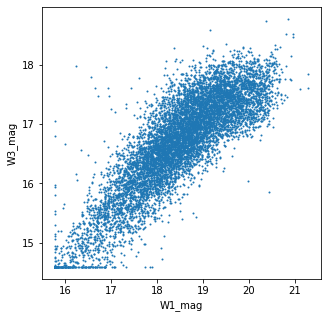

In [231]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(df_train['W1_mag'], df_train['W3_mag'] ,s=1)
plt.xlabel('W1_mag')
plt.ylabel('W3_mag')

In [232]:
# Check correlation for extinction columns
printmd('<font color="red">Train set magnitudes correlation:')
u_ext = df_train['u_extinction']
similar_mags = df_train.corrwith(u_ext)
similar_mags = similar_mags.dropna()
print(similar_mags.sort_values(ascending=False))

printmd('<font color="red">Dev/Test set magnitudes correlation:')
u_ext = df_dev_test['u_extinction']
similar_mags = df_dev_test.corrwith(u_ext)
similar_mags = similar_mags.dropna()
print(similar_mags.sort_values(ascending=False))

<font color="red">Train set magnitudes correlation:

u_extinction    1.000000
r_extinction    0.874587
i_extinction    0.468865
z_extinction    0.467516
e_W2_mag        0.450207
W2_mag          0.409649
e_W1_mag        0.383279
e_u_mag         0.382512
u_mag           0.382275
e_r_mag         0.373746
W3_mag          0.352361
W1_mag          0.334170
e_i_mag         0.332802
e_z_mag         0.322607
AGN             0.320118
i_mag           0.287191
r_mag           0.271774
z_mag           0.268943
g_mag           0.254823
best_z          0.175651
W4_mag          0.160942
e_rf12          0.151865
e_g_mag         0.140119
g_extinction    0.101858
e_rf10         -0.068310
rf10           -0.114020
rf12           -0.116529
DEC            -0.160639
RA             -0.344489
dtype: float64


<font color="red">Dev/Test set magnitudes correlation:

u_extinction    1.000000
r_extinction    0.935174
z_extinction    0.853424
i_extinction    0.853179
g_extinction    0.746316
AGN             0.353638
e_W2_mag        0.222977
e_W1_mag        0.220060
e_rf10          0.215652
rf12            0.168790
e_u_mag         0.166459
rf10            0.147937
e_r_mag         0.118125
e_i_mag         0.102633
best_z          0.095276
W2_mag          0.090092
u_mag           0.067403
W1_mag          0.057260
e_z_mag         0.048824
e_g_mag         0.022949
W3_mag          0.020749
RA             -0.007218
g_mag          -0.026130
r_mag          -0.051860
i_mag          -0.054341
e_rf12         -0.070016
z_mag          -0.075329
W4_mag         -0.151383
DEC            -0.235706
dtype: float64


<font color='green'>Looks like i_extinction and z_extinction is not correlated with u_extinction <br>

In [237]:
# predict missing values of r_mag, g_mag, u_mag, z_mag based on i_mag
mags = ['r_mag', 'g_mag', 'u_mag', 'z_mag']
print('Working on train set:')
for col in mags:
    x = df_train['i_mag']
    y = df_train[col]
    mask = ~np.isnan(x) & ~np.isnan(y)
    slope, intercept, r_value, p_value, std_err = stats.linregress(x[mask],y[mask])
    #print(col,':',non_nan_percent(df_sample,col))
    for index,val in tqdm(df_train[col].items()):
        if np.isnan(val) and not np.isnan(x[index]):
            df_train.at[index,col]= predict(x[index])
            
print('Working on dev/test set:')
for col in mags:
    x = df_dev_test['i_mag']
    y = df_dev_test[col]
    mask = ~np.isnan(x) & ~np.isnan(y)
    slope, intercept, r_value, p_value, std_err = stats.linregress(x[mask],y[mask])
    #print(col,':',non_nan_percent(df_sample,col))
    for index,val in tqdm(df_dev_test[col].items()):
        if np.isnan(val) and not np.isnan(x[index]):
            df_dev_test.at[index,col]= predict(x[index])

15516it [00:00, 160434.13it/s]
0it [00:00, ?it/s]

Working on train set:


15516it [00:00, 158342.24it/s]
15516it [00:00, 158486.08it/s]
15516it [00:00, 193425.04it/s]
15365it [00:00, 276533.08it/s]
15365it [00:00, 278093.90it/s]
15365it [00:00, 274580.78it/s]
0it [00:00, ?it/s]

Working on dev/test set:


15365it [00:00, 303522.81it/s]


In [238]:
# predict missing values of W2, W3 mag based on W1 mag
mags = ['W2_mag','W3_mag']

print('Working on train set:')
for col in mags:
    x = df_train['W1_mag']
    y = df_train[col]
    mask = ~np.isnan(x) & ~np.isnan(y)
    slope, intercept, r_value, p_value, std_err = stats.linregress(x[mask],y[mask])
    #print(col,':',non_nan_percent(df_sample,col))
    for index,val in tqdm(df_train[col].items()):
        if np.isnan(val) and not np.isnan(x[index]):
            df_train.at[index,col]= predict(x[index])
            
print('Working on dev/test set:')
for col in mags:
    x = df_dev_test['W1_mag']
    y = df_dev_test[col]
    mask = ~np.isnan(x) & ~np.isnan(y)
    slope, intercept, r_value, p_value, std_err = stats.linregress(x[mask],y[mask])
    #print(col,':',non_nan_percent(df_sample,col))
    for index,val in tqdm(df_dev_test[col].items()):
        if np.isnan(val) and not np.isnan(x[index]):
            df_dev_test.at[index,col]= predict(x[index])        

7216it [00:00, 72141.84it/s]

Working on train set:


15516it [00:00, 71865.19it/s]
15516it [00:00, 70306.31it/s]
8070it [00:00, 80692.19it/s]

Working on dev/test set:


15365it [00:00, 77178.28it/s]
15365it [00:00, 68649.65it/s]


In [155]:
# predict missing values of extinctions based on u_extinction
mags = ['r_extinction','z_extinction','i_extinction','g_extinction']

print('Working on train set:')
for col in mags:
    x = df_train['u_extinction']
    y = df_train[col]
    mask = ~np.isnan(x) & ~np.isnan(y)
    slope, intercept, r_value, p_value, std_err = stats.linregress(x[mask],y[mask])
    #print(col,':',non_nan_percent(df_sample,col))
    for index,val in tqdm(df_train[col].items()):
        if np.isnan(val) and not np.isnan(x[index]):
            df_train.at[index,col]= predict(x[index])
            
print('Working on dev/test set:')
for col in mags:
    x = df_dev_test['u_extinction']
    y = df_dev_test[col]
    mask = ~np.isnan(x) & ~np.isnan(y)
    slope, intercept, r_value, p_value, std_err = stats.linregress(x[mask],y[mask])
    #print(col,':',non_nan_percent(df_sample,col))
    for index,val in tqdm(df_dev_test[col].items()):
        if np.isnan(val) and not np.isnan(x[index]):
            df_dev_test.at[index,col]= predict(x[index])  

7608it [00:00, 76078.44it/s]

Working on train set:


168577it [00:01, 98529.94it/s] 
168577it [00:01, 87843.94it/s]
168577it [00:02, 83712.90it/s]
168577it [00:01, 86684.02it/s]
9459it [00:00, 94569.35it/s]

Working on dev/test set:


79702it [00:00, 106411.71it/s]
79702it [00:00, 106605.31it/s]
79702it [00:00, 105065.55it/s]
79702it [00:00, 114176.89it/s]


<font color='green'> Now we fill in the remaining missing values in Magnitudes with median of train and dev/test sets.

In [239]:
mags = ['r_mag', 'i_mag', 'u_mag', 'z_mag', 'g_mag',
        'W1_mag', 'W2_mag','W3_mag','W4_mag', 
        'u_extinction', 'r_extinction','z_extinction','i_extinction','g_extinction']
print('Working on Train set..')
for col in mags:
    avg = df_train[col].median(axis=0)
    df_train[col].replace(np.nan, avg, inplace=True)
print('Done')    

print('Working on Dev/Test set..')
for col in mags:
    avg = df_dev_test[col].median(axis=0)
    df_dev_test[col].replace(np.nan, avg, inplace=True)
print('Done')  

Working on Train set..
Done
Working on Dev/Test set..
Done


In [240]:
# Check missing values again
perc = non_nan_percent(df_train,df_train.columns)
printmd('<font color="red">Train set')
print(*perc.items(),sep='\n')

perc = non_nan_percent(df_dev_test,df_dev_test.columns)
printmd('<font color="red">Dev/Test set')
print(*perc.items(),sep='\n')

<font color="red">Train set

('RA', '100.00 %')
('DEC', '100.00 %')
('AGN', '100.00 %')
('i_mag', '100.00 %')
('r_mag', '100.00 %')
('z_mag', '100.00 %')
('u_mag', '100.00 %')
('g_mag', '100.00 %')
('u_extinction', '100.00 %')
('r_extinction', '100.00 %')
('g_extinction', '100.00 %')
('i_extinction', '100.00 %')
('z_extinction', '100.00 %')
('W1_mag', '100.00 %')
('W2_mag', '100.00 %')
('W4_mag', '100.00 %')
('W3_mag', '100.00 %')
('best_z', '91.50 %')
('e_i_mag', '89.08 %')
('e_z_mag', '89.06 %')
('e_r_mag', '87.08 %')
('e_u_mag', '86.98 %')
('e_g_mag', '82.13 %')
('e_rf10', '72.02 %')
('rf10', '72.02 %')
('e_rf12', '72.02 %')
('rf12', '72.02 %')
('e_W1_mag', '55.25 %')
('e_W2_mag', '55.01 %')


<font color="red">Dev/Test set

('RA', '100.00 %')
('DEC', '100.00 %')
('i_mag', '100.00 %')
('r_mag', '100.00 %')
('z_mag', '100.00 %')
('u_mag', '100.00 %')
('g_mag', '100.00 %')
('u_extinction', '100.00 %')
('r_extinction', '100.00 %')
('g_extinction', '100.00 %')
('i_extinction', '100.00 %')
('z_extinction', '100.00 %')
('W1_mag', '100.00 %')
('W2_mag', '100.00 %')
('W4_mag', '100.00 %')
('W3_mag', '100.00 %')
('best_z', '96.96 %')
('e_i_mag', '96.36 %')
('e_z_mag', '96.34 %')
('e_r_mag', '95.70 %')
('e_u_mag', '95.67 %')
('e_g_mag', '94.36 %')
('e_rf10', '91.14 %')
('rf10', '91.14 %')
('e_rf12', '91.14 %')
('rf12', '91.14 %')
('e_W1_mag', '51.97 %')
('e_W2_mag', '51.91 %')
('AGN', '25.25 %')


### Error columns
<font color='green'> For __Error columns__, we fill in 0s for NaN.

In [241]:
err_mags = [col for col in df_train.columns.values if col.startswith('e') or 'error' in col]

for col in err_mags:
    df_train[col].replace(np.nan, 0.0, inplace=True)
    df_dev_test[col].replace(np.nan, 0.0, inplace=True)

### other columns
<font color='green'> For the remaing columns, we fill in Medians for NaN.

In [243]:
print(useful_columns)

['RA', 'DEC', 'best_class', 'best_z', 'i_mag', 'r_mag', 'z_mag', 'u_mag', 'g_mag', 'e_i_mag', 'e_z_mag', 'e_r_mag', 'e_u_mag', 'u_extinction', 'r_extinction', 'e_g_mag', 'g_extinction', 'i_extinction', 'z_extinction', 'e_rf10', 'rf10', 'e_rf12', 'rf12', 'W1_mag', 'W2_mag', 'e_W1_mag', 'W4_mag', 'W3_mag', 'e_W2_mag']


In [244]:
others = ['best_z', 'rf10', 'rf12']
print('Working on Train set..')
for col in others:
    avg = df_train[col].median(axis=0)
    df_train[col].replace(np.nan, avg, inplace=True)
print('Done')    

print('Working on Dev/Test set..')
for col in others:
    avg = df_dev_test[col].median(axis=0)
    df_dev_test[col].replace(np.nan, avg, inplace=True)
print('Done') 

Working on Train set..
Done
Working on Dev/Test set..
Done


In [245]:
# Check missing values again
perc = non_nan_percent(df_train,df_train.columns)
printmd('<font color="red">Train set')
print(*perc.items(),sep='\n')

perc = non_nan_percent(df_dev_test,df_dev_test.columns)
printmd('<font color="red">Dev/Test set')
print(*perc.items(),sep='\n')

<font color="red">Train set

('RA', '100.00 %')
('DEC', '100.00 %')
('AGN', '100.00 %')
('best_z', '100.00 %')
('i_mag', '100.00 %')
('r_mag', '100.00 %')
('z_mag', '100.00 %')
('u_mag', '100.00 %')
('g_mag', '100.00 %')
('e_i_mag', '100.00 %')
('e_z_mag', '100.00 %')
('e_r_mag', '100.00 %')
('e_u_mag', '100.00 %')
('u_extinction', '100.00 %')
('r_extinction', '100.00 %')
('e_g_mag', '100.00 %')
('g_extinction', '100.00 %')
('i_extinction', '100.00 %')
('z_extinction', '100.00 %')
('e_rf10', '100.00 %')
('rf10', '100.00 %')
('e_rf12', '100.00 %')
('rf12', '100.00 %')
('W1_mag', '100.00 %')
('W2_mag', '100.00 %')
('e_W1_mag', '100.00 %')
('W4_mag', '100.00 %')
('W3_mag', '100.00 %')
('e_W2_mag', '100.00 %')


<font color="red">Dev/Test set

('RA', '100.00 %')
('DEC', '100.00 %')
('best_z', '100.00 %')
('i_mag', '100.00 %')
('r_mag', '100.00 %')
('z_mag', '100.00 %')
('u_mag', '100.00 %')
('g_mag', '100.00 %')
('e_i_mag', '100.00 %')
('e_z_mag', '100.00 %')
('e_r_mag', '100.00 %')
('e_u_mag', '100.00 %')
('u_extinction', '100.00 %')
('r_extinction', '100.00 %')
('e_g_mag', '100.00 %')
('g_extinction', '100.00 %')
('i_extinction', '100.00 %')
('z_extinction', '100.00 %')
('e_rf10', '100.00 %')
('rf10', '100.00 %')
('e_rf12', '100.00 %')
('rf12', '100.00 %')
('W1_mag', '100.00 %')
('W2_mag', '100.00 %')
('e_W1_mag', '100.00 %')
('W4_mag', '100.00 %')
('W3_mag', '100.00 %')
('e_W2_mag', '100.00 %')
('AGN', '25.25 %')


## Save dataframes to files

<font color='green'> Split dev/test set into dev and test sets

In [246]:
# labeled data for dev set
df_dev = df_dev_test[~np.isnan(df_dev_test['AGN'])]

# unlabeled data for test set
df_test = df_dev_test[np.isnan(df_dev_test['AGN'])]

<font color='green'> Read train/dev/test reports; make sure that dev and test follows the same distribution. 

In [247]:
# Train set report
profile = ProfileReport(df_train, title='AGN Classifier Training Set Report v1.1.0', minimal=True)
profile.to_file("AGNCL_train_set_report_v1.1.0.html")

# Dev set report
profile = ProfileReport(df_dev, title='AGN Classifier Validation Set Report v1.1.0', minimal=True)
profile.to_file("AGNCL_dev_set_report_v1.1.0.html")

# Test set report
profile = ProfileReport(df_test, title='AGN Classifier Testing Set Report v1.1.0', minimal=True)
profile.to_file("AGNCL_test_set_report_v1.1.0.html")

## Data Issues:
<font color='red'>
<ul>
  <li>error columns have a lot zero values </li>
  <li>missing value is still a problem, leading peaks in the data distribution</li>
</ul>

<font color='green'> Save to files.

In [248]:
df_train.to_pickle('/data/blackbase/notebooks/physics/sicong/AGN_Classifier/version_v1.1.0/version_1/agncl_train.pkl')
df_dev.to_pickle('/data/blackbase/notebooks/physics/sicong/AGN_Classifier/version_v1.1.0/version_1/agncl_dev.pkl')
df_test.to_pickle('/data/blackbase/notebooks/physics/sicong/AGN_Classifier/version_v1.1.0/version_1/agncl_test.pkl')

In [249]:
df_train = pd.read_pickle('/data/blackbase/notebooks/physics/sicong/AGN_Classifier/version_v1.1.0/version_1/agncl_train.pkl')
df_dev = pd.read_pickle('/data/blackbase/notebooks/physics/sicong/AGN_Classifier/version_v1.1.0/version_1/agncl_dev.pkl')
df_test = pd.read_pickle('/data/blackbase/notebooks/physics/sicong/AGN_Classifier/version_v1.1.0/version_1/agncl_test.pkl')

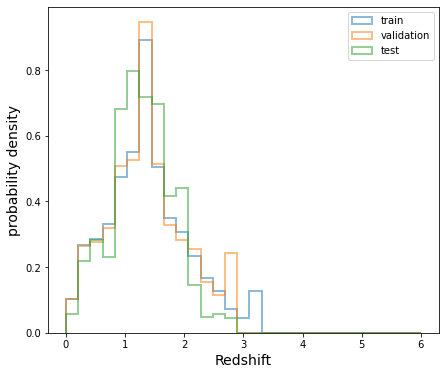

In [250]:
# check z distribution
bins_red = np.linspace(0, 6, 30)

plt.figure(figsize=(7,6))
plt.hist(df_train['best_z'], bins=bins_red, alpha=0.5, label="train", density=True, histtype='step',linewidth=2, log=False)
plt.hist(df_dev['best_z'], bins=bins_red, alpha=0.5, label="validation", density=True, histtype='step',linewidth=2, log=False)
plt.hist(df_test['best_z'], bins=bins_red, alpha=0.5, label="test", density=True, histtype='step',linewidth=2, log=False)

plt.xlabel("Redshift", size=14)
plt.ylabel("probability density", size=14)

#plt.ylim([0, 2])

#plt.title("Redshift distribution")
plt.legend(loc='upper right')

plt.savefig('z_hist.pdf')

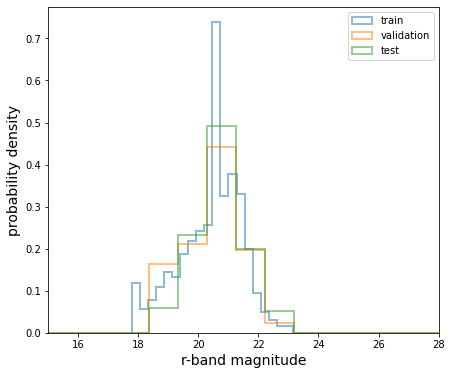

In [82]:
# check r_mag distribution
bins_red = np.linspace(0, 28, 30)

plt.figure(figsize=(7,6))
plt.hist(df_train['r_mag'], bins=20, alpha=0.5, label="train", density=True, histtype='step',linewidth=2, log=False)
plt.hist(df_dev['r_mag'], bins=bins_red, alpha=0.5, label="validation", density=True, histtype='step',linewidth=2, log=False)
plt.hist(df_test['r_mag'], bins=bins_red, alpha=0.5, label="test", density=True, histtype='step',linewidth=2, log=False)

plt.xlabel("r-band magnitude", size=14)
plt.ylabel("probability density", size=14)

#plt.ylim([0, 2])
plt.xlim([15, 28])

#plt.title("Redshift distribution")
plt.legend(loc='upper right')

plt.savefig('r_mag_hist.pdf')

## Tsne

### Down sampling

In [252]:
# percentage of agn in our sample
printmd('<font color="red"> Training set:')
agn_perc = len(df_train[df_train['AGN'] == 1])/len(df_train['AGN'])
non_agn_perc = len(df_train[df_train['AGN'] == 0])/len(df_train['AGN'])
print(f'{100*agn_perc:.2f}% are agns, {100*non_agn_perc:.2f}% are non-agns')

printmd('<font color="red"> Dev set:')
agn_perc = len(df_dev[df_dev['AGN'] == 1])/len(df_dev['AGN'])
non_agn_perc = len(df_dev[df_dev['AGN'] == 0])/len(df_dev['AGN'])
print(f'{100*agn_perc:.2f}% are agns, {100*non_agn_perc:.2f}% are non-agns')

<font color="red"> Training set:

50.28% are agns, 49.72% are non-agns


<font color="red"> Dev set:

48.87% are agns, 51.13% are non-agns


In [253]:
len(df_train[df_train['AGN'] == 1])

7802

In [254]:
# select features
features = df_train.columns.values.tolist()
features.remove('AGN')
features.remove('RA')
features.remove('DEC')

targets = set(df_train["AGN"].unique())
print(targets,features,sep='\n')

{0.0, 1.0}
['best_z', 'i_mag', 'r_mag', 'z_mag', 'u_mag', 'g_mag', 'e_i_mag', 'e_z_mag', 'e_r_mag', 'e_u_mag', 'u_extinction', 'r_extinction', 'e_g_mag', 'g_extinction', 'i_extinction', 'z_extinction', 'e_rf10', 'rf10', 'e_rf12', 'rf12', 'W1_mag', 'W2_mag', 'e_W1_mag', 'W4_mag', 'W3_mag', 'e_W2_mag']


<font color='green'> Resample points so that we have approximately the same number of each morphological class for the t-sne plot

In [255]:
rows_by_class = {target: df_train[df_train["AGN"] == target] for target in targets}
to_concat = []
for target, target_df in rows_by_class.items():
    print(target, len(target_df), target_df.shape)
    
    nan_counts = np.isnan(target_df[features].values).sum(axis=1)
    sort_indices = np.argsort(nan_counts)
    least_nan = target_df.iloc[sort_indices].iloc[:6000]  # number of sources to select from each category
    to_concat.append(least_nan)

tmp = pd.concat(to_concat)
examples = tmp[features].values
best_class = tmp["AGN"].values

# shuffle points again; this is just for visualization so points are not drawn on top of each other
shuffle_indices = np.random.permutation(len(examples))
examples = examples[shuffle_indices]
best_class = best_class[shuffle_indices]
print(examples.shape)

0.0 7714 (7714, 29)
1.0 7802 (7802, 29)
(12000, 26)


<font color='green'>Normalize data to standard units.

In [257]:
examples = (examples - examples.mean(axis=0)) / (examples.std(axis=0))

<font color='green'>Apply tsne

In [259]:
%%time
# perplexity = 30

X_embedded = TSNE(n_components=2, perplexity=30).fit_transform(examples)
print(X_embedded)

[[ 39.458088    65.88211   ]
 [-36.594967   -42.80628   ]
 [-52.306374   -24.98285   ]
 ...
 [  0.14129698 -35.887386  ]
 [-61.271782    20.781212  ]
 [ 27.777357    13.383024  ]]
CPU times: user 1h 31min 30s, sys: 5.21 s, total: 1h 31min 35s
Wall time: 3min 17s


In [267]:
best_class = np.where(best_class == 0., "non-AGN", "AGN")
embed_df = pd.DataFrame(X_embedded, columns=['Dimension 1', 'Dimension 2'])
embed_df['labels'] = best_class

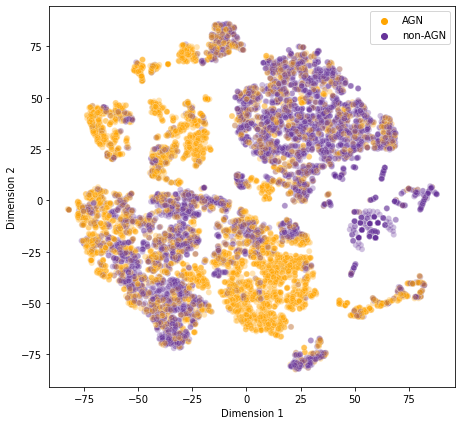

In [268]:
plt.figure(figsize=(16,7))
ax1 = plt.subplot(1, 2, 1)
hue_order = ['AGN', 'non-AGN']
sns.scatterplot(
    x="Dimension 1", y="Dimension 2",
    hue="labels",
    hue_order=hue_order,
    palette=["orange", 'rebeccapurple'],
    data=embed_df,
    legend="full",
    alpha=0.3,
    ax=ax1
)
ax1.legend_.set_title(None)


# ax2 = plt.subplot(1, 2, 2)
# hue_order = ['Type-1', 'Type-2']
# sns.scatterplot(
#     x="Dimension 1", y="Dimension 2",
#     hue="labels",
#     hue_order=hue_order,
#     palette=["orange", 'rebeccapurple'],
#     data=agn_df,
#     legend="full",
#     alpha=0.3,
#     ax=ax2
# )
# ax2.legend_.set_title(None)
plt.savefig('tsne.pdf',dpi=300)